<a href="https://colab.research.google.com/github/CHIN-HUA/gcn_colab/blob/main/Copy_of_Parallelization_of_Graph_Convolutional_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# To show that if there is cuda tookit installed
!ls /usr/local

bin    cuda	cuda-11.8  games	       include	lib64	   man	 share
colab  cuda-11	etc	   _gcs_config_ops.so  lib	licensing  sbin  src


In [ ]:
# To show that if there is cuda tookit installed
!ls /usr/local

bin    cuda	cuda-11.8  games	       include	lib64	   man	 share
colab  cuda-11	etc	   _gcs_config_ops.so  lib	licensing  sbin  src


In [ ]:
# To show the property of the nvidia card(On my one, I use the K80)
!nvidia-smi

Mon May 15 14:41:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Write a cu file contain the host and kernel code
%%writefile hello.cu

#include <iostream>
#include <cuda.h>

__global__ void hello(void)
{
  printf("GPU: Hello!\n");
}
int main(int argc,char **argv)
{
  printf("CPU: Hello!\n");
  hello<<<1,10>>>();
  cudaDeviceReset();
  return 0;
}

Overwriting hello.cu


In [ ]:
!nvcc -Wno-deprecated-gpu-targets hello.cu -o hello

!./hello

CPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!


In [ ]:
'''
MIT License
Copyright (c) 2020 Ronald Seoh
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

# torch.device / CUDA Setup
import torch

use_cuda = True
use_colab_tpu = False
colab_tpu_available = False

if use_colab_tpu:
    try:
        assert os.environ['COLAB_TPU_ADDR']
        colab_tpu_available = True
    except:
        colab_tpu_available = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    # Set this to True to make your output immediately reproducible
    # Note: https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.deterministic = False

    # Disable 'benchmark' mode: Set this False if you want to measure running times more fairly
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = True

    # Faster Host to GPU copies with page-locked memory
    use_pin_memory = True

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))

elif use_colab_tpu and colab_tpu_available:
    # This needs to be installed separately
    # https://github.com/pytorch/xla/blob/master/contrib/colab/getting-started.ipynb
    import torch_xla
    import torch_xla.core.xla_model as xm

    torch_device = xm.xla_device()

else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

CUDA Version: 11.8
cuDNN Version: 8700
CUDA Device Name: Tesla T4
CUDA Capabilities: (7, 5)


In [72]:
!git clone https://github.com/hengdashi/cuda_gcn.git

fatal: destination path 'cuda_gcn' already exists and is not an empty directory.


In [ ]:
!ls ./cuda_gcn/

data.tgz  Makefile  README.md  reddit_preprocess.py  report  src


In [73]:
# author: chinhua
#https://blog.csdn.net/zzc_zhuyu/article/details/89929129
# 利用硬件实现矩阵乘法加速
#矩陣鏈乘法（或矩陣鏈排序問題[1]）是關於以最有效的方式乘以給定矩陣序列的優化問題。問題實際上不是執行乘法，而只是決定所涉及的矩陣乘法的順序。該問題可以使用動態規劃來解決。
%%writefile ./cuda_gcn/src/cuda/cuda_kernel.cu
#include "cuda_kernel.cuh"

curandState *devStates;

// matrix mult
__global__
void cuda_Matmul_forward_kernel(const float *a, const float *b, float *c, const uint m, const uint n, const uint p) {
    __shared__ float tileA[TILE_SIZE][TILE_SIZE];
    __shared__ float tileB[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;
    int range = (n-1) / TILE_SIZE + 1;
    float res = 0;

    #pragma unroll
    for (int i = 0; i < range; i++) {
        if (row < m && i * TILE_SIZE + tx < n)
            tileA[ty][tx] = a[row * n + i * TILE_SIZE + tx];
        else
            tileA[ty][tx] = 0;
        if (col < p && i * TILE_SIZE + ty < n)
            tileB[ty][tx] = b[(i * TILE_SIZE + ty) * p + col];
        else
            tileB[ty][tx] = 0;

        __syncthreads();
        #pragma unroll
        for (int j = 0; j < TILE_SIZE; j++)
            res += tileA[ty][j] * tileB[j][tx];
        __syncthreads();
    }
    if (row < m && col < p)
        c[row * p + col] = res;
}

__global__
void cuda_Matmul_backward_A_kernel(float *a_grad, const float *b, const float *c_grad, const uint m, const uint n, const uint p) {
    __shared__ float tileB[TILE_SIZE][TILE_SIZE];
    __shared__ float tileCGrad[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;
    int range = (p-1) / TILE_SIZE + 1;
    float res = 0;
    #pragma unroll
    for (int i = 0; i < range; i++) {
        if (row < m && i * TILE_SIZE + tx < p)
            tileCGrad[ty][tx] = c_grad[row * p + i * TILE_SIZE + tx];
        else
            tileCGrad[ty][tx] = 0;
        if (col < n && i * TILE_SIZE + ty < p)
            tileB[ty][tx] = b[col * p + i * TILE_SIZE + ty];
        else
            tileB[ty][tx] = 0;
        __syncthreads();

        #pragma unroll
        for (int j = 0; j < TILE_SIZE; j++)
            res += tileCGrad[ty][j] * tileB[j][tx];
        __syncthreads();
    }
    if (row < m && col < n)
        a_grad[row * n + col] = res;
}

__global__
void cuda_Matmul_backward_B_kernel(float *b_grad, const float *a, const float *c_grad, const uint m, const uint n, const uint p) {
    __shared__ float tileA[TILE_SIZE][TILE_SIZE];
    __shared__ float tileCGrad[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;
    int range = (m-1)/TILE_SIZE+1;
    float res = 0;

    #pragma unroll
    for (int i = 0; i < range; i++) {
        if (row < n && i * TILE_SIZE + tx < m)
            tileA[ty][tx] = a[(i * TILE_SIZE + tx) * n + row];
        else
            tileA[ty][tx] = 0;
        if (col < p && i * TILE_SIZE + ty < m)
            tileCGrad[ty][tx] = c_grad[(i * TILE_SIZE + ty) * p + col];
        else
            tileCGrad[ty][tx] = 0;
        __syncthreads();

        #pragma unroll
        for (int j = 0; j < TILE_SIZE; j++)
            res += tileA[ty][j] * tileCGrad[j][tx];
        __syncthreads();
    }
    if (row < n && col < p)
        b_grad[row * p + col] = res;
}


// sparse matmul
__global__
void cuda_SparseMatmul_forward_kernel(float *a_in, float *b_in, float *c_in, int *indptr, int *indices, int p) {
    int i = blockIdx.x;
    int k = threadIdx.x;

    #pragma unroll
    for (int jj = indptr[i]; jj < indptr[i + 1]; jj++) {
        int j = indices[jj];
        c_in[i * p + k] += a_in[jj] * b_in[j * p + k];
    }
}

__global__
void cuda_SparseMatmul_backward_kernel(float *a_in, float *b_in, float *c_in, int *indptr, int *indices, int p) {
    int i = blockIdx.x;
    int k = threadIdx.x;

    #pragma unroll
    for (int jj = indptr[i]; jj < indptr[i + 1]; jj++){
        int j = indices[jj];
        b_in[j * p + k] += c_in[i * p + k] * a_in[jj];
    }
}


// graph sum
__global__
void cuda_GraphSum_forward_kernel(float *d_in_data, float *d_out_data, int *d_indptr, int *d_indices, int dim, int numNodes) {
    int src = blockIdx.x;
    int j = threadIdx.x;

    int ptr_src_0 = d_indptr[src];
    int ptr_stc_1 = d_indptr[src + 1];

    #pragma unroll
    for (int i = ptr_src_0; i < ptr_stc_1; i++) {
        int dst = d_indices[i];
        float coef = 1.0 / sqrtf(
                (ptr_stc_1 - ptr_src_0) * (d_indptr[dst + 1] - d_indptr[dst])
        );
        // This only works for undirected graphs. Should be out[dst] += coef * in[src]]
        d_out_data[src * dim + j] += coef * d_in_data[dst * dim + j];
    }
}

__global__
void cuda_GraphSum_backward_kernel(float *d_in_grad, float *d_out_grad, int *d_indptr, int *d_indices, int dim, int numNodes) {
    int src = blockIdx.x;
    int j = threadIdx.x;

    int ptr_src_0 = d_indptr[src];
    int ptr_stc_1 = d_indptr[src + 1];

    #pragma unroll
    for (int i = ptr_src_0; i < ptr_stc_1; i++) {
        int dst = d_indices[i];
        float coef = 1.0 / sqrtf(
                (ptr_stc_1 - ptr_src_0) * (d_indptr[dst + 1] - d_indptr[dst])
        );
        // This only works for undirected graphs. Should be out[dst] += coef * in[src]
        d_in_grad[src * dim + j] += coef * d_out_grad[dst * dim + j];
    }
}


// cross entropy
__global__
void cuda_CrossEntropy_forward_A_kernel(float* logits_data, float* logits_grad, bool training, int num_classes, int* truth, int* count, float* thread_loss, int size) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= size) return;
    if (truth[i] < 0) {
        count[i] = 0;
        return;
    }
    float *logit = &logits_data[i * num_classes];
    float max_logit = -1e30, sum_exp = 0;
    #pragma unroll
    for (int j = 0; j < num_classes; j++)
        max_logit = fmax(max_logit, logit[j]);
    #pragma unroll
    for (int j = 0; j < num_classes; j++) {
        logit[j] -= max_logit;
        sum_exp += expf(logit[j]);
    }
    if (training) {
        #pragma unroll
        for (int j = 0; j < num_classes; j++) {
            float prob = expf(logit[j]) / sum_exp;
            logits_grad[i * num_classes + j] = prob;
        }
        logits_grad[i * num_classes + truth[i]] -= 1.0;
    }
    count[i] = 1;
    thread_loss[i] = logf(sum_exp) - logit[truth[i]];
}

__global__
void cuda_CrossEntropy_forward_B_kernel(float *logits_grad, int size, int count) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) logits_grad[i] /= count;
}


// ReLU
__global__
void cuda_ReLU_forward_kernel(float *d_in_data, bool *d_mask, const long unsigned int datasize, bool training) {
    uint i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= datasize) return;

    bool keep = d_in_data[i] > 0;
    if (training) d_mask[i] = keep;
    if (!keep) d_in_data[i] = 0;
}

__global__
void cuda_ReLU_backward_kernel(float *d_in_grad, bool *d_mask, long unsigned int datasize) {
    uint i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= datasize) return;
    if (!d_mask[i]) d_in_grad[i] = 0;
}


// Dropout
__global__
void cuda_Dropout_forward_kernel(float *in, int *mask, curandState *state, const uint size, const float p, const float scale, const bool useMask) {
    float x;
    bool keep;
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size) {
        x = curand_uniform(&state[id % MAX_THREAD_PER_BLOCK]);
        keep = x >= p;
        in[id] *= keep ? scale : 0;
        if (useMask) mask[id] = keep;
    }
}

__global__
void cuda_Dropout_backward_kernel(float *in_grad, const int *mask, const uint size, const float scale) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size) in_grad[id] *= mask[id] ? scale : 0;
}


// rand state
__global__
void cuda_init_rand_kernel(curandState *state) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    curand_init(1234, id, 0, &state[id]);
}

void cuda_init_random_state(const uint size) {
    // malloc
    CUDA_CHECK(cudaMalloc((void**) &devStates, size * sizeof(curandState)));

    dim3 block((size-1)/MAX_THREAD_PER_BLOCK + 1, 1, 1);
    dim3 thread_in_block(MAX_THREAD_PER_BLOCK, 1, 1);

    // kernel
    cuda_init_rand_kernel<<<block,thread_in_block>>>(devStates);
    CUDA_CHECK(cudaGetLastError());
    // CUDA_CHECK(cudaDeviceSynchronize());
}

void cuda_free_random_state() {
    // free
    CUDA_CHECK(cudaFree(devStates));
}


// adam
__global__
void cuda_Adam_step_kernel(float* grad, float* data, float* m, float* v, bool decay, float weight_decay, float beta1, float beta2, float eps, float step_size, int varsize) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    if (i >= varsize) return;

    float g = grad[i];
    if (decay) g += weight_decay * data[i];
    m[i] = beta1 * m[i] + (1.0 - beta1) * g;
    v[i] = beta2 * v[i] + (1.0 - beta2) * g * g;
    data[i] -= step_size * m[i] / (sqrtf(v[i]) + eps);
}

__global__
void cuda_set_truth_kernel(int *truth, int *data_split, int *data_label, int current_split, int size) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size)
        truth[id] = data_split[id] == current_split ? data_label[id] : -1;
}

__global__
void cuda_Variable_glorot_kernel(float *data, curandState *state, int size, float scale) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size)
        data[id] = (curand_uniform(&state[id % MAX_THREAD_PER_BLOCK]) - 0.5) * scale;
}

Overwriting ./cuda_gcn/src/cuda/cuda_kernel.cu


In [ ]:
!ls
! ls cuda_gcn
! cd cuda_gcn && make cuda

cuda_gcn  sample_data
data.tgz  Makefile  README.md  reddit_preprocess.py  report  src
nvcc -dc -O3 -std=c++11 -Isrc -Isrc/common -Isrc/seq -Isrc/cuda src/main.cpp -o src/cudamain.o
In file included from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config/config.h:27,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config.h:23,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/extrema.h:23,
                 from src/cuda/cuda_kernel.cuh:4,
                 from src/cuda/cuda_variable.cuh:4,
                 from src/cuda/cuda_gcn.cuh:5,
                 from src/main.cpp:10:
/usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config/cpp_dialect.h:131:13: warning: Thrust requires at least C++14. C++11 is deprecated but still supported. C++11 support will be removed in a future release. Define THRUST_IGNORE_DEPRECATED_CPP_DIALECT to suppress this message.
  131 |      THRUST_COMPILER

In [74]:
!ls
!cd cuda_gcn && tar -xvzf data.tgz
!ls
! cd cuda_gcn && ./cuda_gcn cora > first.txt

cuda_gcn  sample_data
data/citeseer.graph
data/citeseer.split
data/citeseer.svmlight
data/cora.graph
data/cora.split
data/cora.svmlight
data/pubmed.graph
data/pubmed.split
data/pubmed.svmlight
cuda_gcn  sample_data


In [75]:
# author: chinhua
#https://blog.csdn.net/zzc_zhuyu/article/details/89929129
# 利用硬件实现矩阵乘法加速
#矩陣鏈乘法（或矩陣鏈排序問題[1]）是關於以最有效的方式乘以給定矩陣序列的優化問題。問題實際上不是執行乘法，而只是決定所涉及的矩陣乘法的順序。該問題可以使用動態規劃來解決。
%%writefile ./cuda_gcn/src/cuda/cuda_kernel.cu

#include "cuda_kernel.cuh"

curandState *devStates;


__global__ void cuda_Matmul_forward_kernel(const float *a, const float *b, float *c, const uint m, const uint n, const uint p) {
    __shared__ float tileA[TILE_SIZE][TILE_SIZE];
    __shared__ float tileB[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;

    // Initialize partial result
    float res_kij = 0;

    for (int k = 0; k < (n-1) / TILE_SIZE + 1; ++k) {
        // Load tileA
        if (row < m && k * TILE_SIZE + tx < n)
            tileA[ty][tx] = a[row * n + k * TILE_SIZE + tx];
        else
            tileA[ty][tx] = 0;

        // Load tileB
        if (col < p && k * TILE_SIZE + ty < n)
            tileB[ty][tx] = b[(k * TILE_SIZE + ty) * p + col];
        else
            tileB[ty][tx] = 0;

        __syncthreads();

        // Compute partial result for each tile
        for (int i = 0; i < TILE_SIZE; ++i) {
            if (row < m && col < p)
                res_kij += tileA[ty][i] * tileB[i][tx];
        }

        __syncthreads();
    }

    // Store the final result
    if (row < m && col < p)
        c[row * p + col] = res_kij;
}


__global__
void cuda_Matmul_backward_A_kernel(float *a_grad, const float *b, const float *c_grad, const uint m, const uint n, const uint p) {
    __shared__ float tileB[TILE_SIZE][TILE_SIZE];
    __shared__ float tileCGrad[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;
    int range = (p-1) / TILE_SIZE + 1;
    float res = 0;
    #pragma unroll
    for (int i = 0; i < range; i++) {
        if (row < m && i * TILE_SIZE + tx < p)
            tileCGrad[ty][tx] = c_grad[row * p + i * TILE_SIZE + tx];
        else
            tileCGrad[ty][tx] = 0;
        if (col < n && i * TILE_SIZE + ty < p)
            tileB[ty][tx] = b[col * p + i * TILE_SIZE + ty];
        else
            tileB[ty][tx] = 0;
        __syncthreads();

        #pragma unroll
        for (int j = 0; j < TILE_SIZE; j++)
            res += tileCGrad[ty][j] * tileB[j][tx];
        __syncthreads();
    }
    if (row < m && col < n)
        a_grad[row * n + col] = res;
}

__global__
void cuda_Matmul_backward_B_kernel(float *b_grad, const float *a, const float *c_grad, const uint m, const uint n, const uint p) {
    __shared__ float tileA[TILE_SIZE][TILE_SIZE];
    __shared__ float tileCGrad[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;
    int range = (m-1)/TILE_SIZE+1;
    float res = 0;

    #pragma unroll
    for (int i = 0; i < range; i++) {
        if (row < n && i * TILE_SIZE + tx < m)
            tileA[ty][tx] = a[(i * TILE_SIZE + tx) * n + row];
        else
            tileA[ty][tx] = 0;
        if (col < p && i * TILE_SIZE + ty < m)
            tileCGrad[ty][tx] = c_grad[(i * TILE_SIZE + ty) * p + col];
        else
            tileCGrad[ty][tx] = 0;
        __syncthreads();

        #pragma unroll
        for (int j = 0; j < TILE_SIZE; j++)
            res += tileA[ty][j] * tileCGrad[j][tx];
        __syncthreads();
    }
    if (row < n && col < p)
        b_grad[row * p + col] = res;
}


// sparse matmul
__global__
void cuda_SparseMatmul_forward_kernel(float *a_in, float *b_in, float *c_in, int *indptr, int *indices, int p) {
    int i = blockIdx.x;
    int k = threadIdx.x;

    #pragma unroll
    for (int jj = indptr[i]; jj < indptr[i + 1]; jj++) {
        int j = indices[jj];
        c_in[i * p + k] += a_in[jj] * b_in[j * p + k];
    }
}

__global__
void cuda_SparseMatmul_backward_kernel(float *a_in, float *b_in, float *c_in, int *indptr, int *indices, int p) {
    int i = blockIdx.x;
    int k = threadIdx.x;

    #pragma unroll
    for (int jj = indptr[i]; jj < indptr[i + 1]; jj++){
        int j = indices[jj];
        b_in[j * p + k] += c_in[i * p + k] * a_in[jj];
    }
}


// graph sum
__global__
void cuda_GraphSum_forward_kernel(float *d_in_data, float *d_out_data, int *d_indptr, int *d_indices, int dim, int numNodes) {
    int src = blockIdx.x;
    int j = threadIdx.x;

    int ptr_src_0 = d_indptr[src];
    int ptr_stc_1 = d_indptr[src + 1];

    #pragma unroll
    for (int i = ptr_src_0; i < ptr_stc_1; i++) {
        int dst = d_indices[i];
        float coef = 1.0 / sqrtf(
                (ptr_stc_1 - ptr_src_0) * (d_indptr[dst + 1] - d_indptr[dst])
        );
        // This only works for undirected graphs. Should be out[dst] += coef * in[src]]
        d_out_data[src * dim + j] += coef * d_in_data[dst * dim + j];
    }
}

__global__
void cuda_GraphSum_backward_kernel(float *d_in_grad, float *d_out_grad, int *d_indptr, int *d_indices, int dim, int numNodes) {
    int src = blockIdx.x;
    int j = threadIdx.x;

    int ptr_src_0 = d_indptr[src];
    int ptr_stc_1 = d_indptr[src + 1];

    #pragma unroll
    for (int i = ptr_src_0; i < ptr_stc_1; i++) {
        int dst = d_indices[i];
        float coef = 1.0 / sqrtf(
                (ptr_stc_1 - ptr_src_0) * (d_indptr[dst + 1] - d_indptr[dst])
        );
        // This only works for undirected graphs. Should be out[dst] += coef * in[src]
        d_in_grad[src * dim + j] += coef * d_out_grad[dst * dim + j];
    }
}


// cross entropy
__global__
void cuda_CrossEntropy_forward_A_kernel(float* logits_data, float* logits_grad, bool training, int num_classes, int* truth, int* count, float* thread_loss, int size) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= size) return;
    if (truth[i] < 0) {
        count[i] = 0;
        return;
    }
    float *logit = &logits_data[i * num_classes];
    float max_logit = -1e30, sum_exp = 0;
    #pragma unroll
    for (int j = 0; j < num_classes; j++)
        max_logit = fmax(max_logit, logit[j]);
    #pragma unroll
    for (int j = 0; j < num_classes; j++) {
        logit[j] -= max_logit;
        sum_exp += expf(logit[j]);
    }
    if (training) {
        #pragma unroll
        for (int j = 0; j < num_classes; j++) {
            float prob = expf(logit[j]) / sum_exp;
            logits_grad[i * num_classes + j] = prob;
        }
        logits_grad[i * num_classes + truth[i]] -= 1.0;
    }
    count[i] = 1;
    thread_loss[i] = logf(sum_exp) - logit[truth[i]];
}

__global__
void cuda_CrossEntropy_forward_B_kernel(float *logits_grad, int size, int count) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) logits_grad[i] /= count;
}


// ReLU
__global__
void cuda_ReLU_forward_kernel(float *d_in_data, bool *d_mask, const long unsigned int datasize, bool training) {
    uint i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= datasize) return;

    bool keep = d_in_data[i] > 0;
    if (training) d_mask[i] = keep;
    if (!keep) d_in_data[i] = 0;
}

__global__
void cuda_ReLU_backward_kernel(float *d_in_grad, bool *d_mask, long unsigned int datasize) {
    uint i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= datasize) return;
    if (!d_mask[i]) d_in_grad[i] = 0;
}


// Dropout
__global__
void cuda_Dropout_forward_kernel(float *in, int *mask, curandState *state, const uint size, const float p, const float scale, const bool useMask) {
    float x;
    bool keep;
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size) {
        x = curand_uniform(&state[id % MAX_THREAD_PER_BLOCK]);
        keep = x >= p;
        in[id] *= keep ? scale : 0;
        if (useMask) mask[id] = keep;
    }
}

__global__
void cuda_Dropout_backward_kernel(float *in_grad, const int *mask, const uint size, const float scale) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size) in_grad[id] *= mask[id] ? scale : 0;
}


// rand state
__global__
void cuda_init_rand_kernel(curandState *state) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    curand_init(1234, id, 0, &state[id]);
}

void cuda_init_random_state(const uint size) {
    // malloc
    CUDA_CHECK(cudaMalloc((void**) &devStates, size * sizeof(curandState)));

    dim3 block((size-1)/MAX_THREAD_PER_BLOCK + 1, 1, 1);
    dim3 thread_in_block(MAX_THREAD_PER_BLOCK, 1, 1);

    // kernel
    cuda_init_rand_kernel<<<block,thread_in_block>>>(devStates);
    CUDA_CHECK(cudaGetLastError());
    // CUDA_CHECK(cudaDeviceSynchronize());
}

void cuda_free_random_state() {
    // free
    CUDA_CHECK(cudaFree(devStates));
}


// adam
__global__
void cuda_Adam_step_kernel(float* grad, float* data, float* m, float* v, bool decay, float weight_decay, float beta1, float beta2, float eps, float step_size, int varsize) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    if (i >= varsize) return;

    float g = grad[i];
    if (decay) g += weight_decay * data[i];
    m[i] = beta1 * m[i] + (1.0 - beta1) * g;
    v[i] = beta2 * v[i] + (1.0 - beta2) * g * g;
    data[i] -= step_size * m[i] / (sqrtf(v[i]) + eps);
}

__global__
void cuda_set_truth_kernel(int *truth, int *data_split, int *data_label, int current_split, int size) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size)
        truth[id] = data_split[id] == current_split ? data_label[id] : -1;
}

__global__
void cuda_Variable_glorot_kernel(float *data, curandState *state, int size, float scale) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size)
        data[id] = (curand_uniform(&state[id % MAX_THREAD_PER_BLOCK]) - 0.5) * scale;
}



Overwriting ./cuda_gcn/src/cuda/cuda_kernel.cu


In [76]:
! cd cuda_gcn && make cuda

nvcc -dc -O3 -std=c++11 -Isrc -Isrc/common -Isrc/seq -Isrc/cuda src/cuda/cuda_kernel.cu -o src/cuda/cuda_kernel.o
In file included from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config/config.h:27,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config.h:23,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/extrema.h:23,
                 from src/cuda/cuda_kernel.cuh:4,
                 from src/cuda/cuda_kernel.cu:2:
/usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config/cpp_dialect.h:131:13: warning: Thrust requires at least C++14. C++11 is deprecated but still supported. C++11 support will be removed in a future release. Define THRUST_IGNORE_DEPRECATED_CPP_DIALECT to suppress this message.
  131 |      THRUST_COMPILER_DEPRECATION_SOFT(C++14, C++11);
      |             ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~                                                                

In [77]:
! cd cuda_gcn && ./cuda_gcn cora > kij.txt

In [78]:
# author: chinhua
#https://blog.csdn.net/zzc_zhuyu/article/details/89929129
# 利用硬件实现矩阵乘法加速
#矩陣鏈乘法（或矩陣鏈排序問題[1]）是關於以最有效的方式乘以給定矩陣序列的優化問題。問題實際上不是執行乘法，而只是決定所涉及的矩陣乘法的順序。該問題可以使用動態規劃來解決。
%%writefile ./cuda_gcn/src/cuda/cuda_kernel.cu

#include "cuda_kernel.cuh"

curandState *devStates;


__global__ void cuda_Matmul_forward_kernel(const float *a, const float *b, float *c, const uint m, const uint n, const uint p) {
    __shared__ float tileA[TILE_SIZE][TILE_SIZE];
    __shared__ float tileB[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;

    // Initialize partial result
    float res_ijk = 0;

    for (int i = 0; i < (m-1) / TILE_SIZE + 1; ++i) {
        // Load tileA
        if (i * TILE_SIZE + ty < m && col < n)
            tileA[ty][tx] = a[(i * TILE_SIZE + ty) * n + col];
        else
            tileA[ty][tx] = 0;

        // Load tileB
        if (row < n && i * TILE_SIZE + tx < p)
            tileB[ty][tx] = b[row * p + i * TILE_SIZE + tx];
        else
            tileB[ty][tx] = 0;

        __syncthreads();

        // Compute partial result for each tile
        for (int j = 0; j < TILE_SIZE; ++j) {
            if (row < n && col < p)
                res_ijk += tileA[ty][j] * tileB[j][tx];
        }

        __syncthreads();
    }

    // Store the final result
    if (row < n && col < p)
        c[row * p + col] = res_ijk;
}


__global__
void cuda_Matmul_backward_A_kernel(float *a_grad, const float *b, const float *c_grad, const uint m, const uint n, const uint p) {
    __shared__ float tileB[TILE_SIZE][TILE_SIZE];
    __shared__ float tileCGrad[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;
    int range = (p-1) / TILE_SIZE + 1;
    float res = 0;
    #pragma unroll
    for (int i = 0; i < range; i++) {
        if (row < m && i * TILE_SIZE + tx < p)
            tileCGrad[ty][tx] = c_grad[row * p + i * TILE_SIZE + tx];
        else
            tileCGrad[ty][tx] = 0;
        if (col < n && i * TILE_SIZE + ty < p)
            tileB[ty][tx] = b[col * p + i * TILE_SIZE + ty];
        else
            tileB[ty][tx] = 0;
        __syncthreads();

        #pragma unroll
        for (int j = 0; j < TILE_SIZE; j++)
            res += tileCGrad[ty][j] * tileB[j][tx];
        __syncthreads();
    }
    if (row < m && col < n)
        a_grad[row * n + col] = res;
}

__global__
void cuda_Matmul_backward_B_kernel(float *b_grad, const float *a, const float *c_grad, const uint m, const uint n, const uint p) {
    __shared__ float tileA[TILE_SIZE][TILE_SIZE];
    __shared__ float tileCGrad[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;
    int range = (m-1)/TILE_SIZE+1;
    float res = 0;

    #pragma unroll
    for (int i = 0; i < range; i++) {
        if (row < n && i * TILE_SIZE + tx < m)
            tileA[ty][tx] = a[(i * TILE_SIZE + tx) * n + row];
        else
            tileA[ty][tx] = 0;
        if (col < p && i * TILE_SIZE + ty < m)
            tileCGrad[ty][tx] = c_grad[(i * TILE_SIZE + ty) * p + col];
        else
            tileCGrad[ty][tx] = 0;
        __syncthreads();

        #pragma unroll
        for (int j = 0; j < TILE_SIZE; j++)
            res += tileA[ty][j] * tileCGrad[j][tx];
        __syncthreads();
    }
    if (row < n && col < p)
        b_grad[row * p + col] = res;
}


// sparse matmul
__global__
void cuda_SparseMatmul_forward_kernel(float *a_in, float *b_in, float *c_in, int *indptr, int *indices, int p) {
    int i = blockIdx.x;
    int k = threadIdx.x;

    #pragma unroll
    for (int jj = indptr[i]; jj < indptr[i + 1]; jj++) {
        int j = indices[jj];
        c_in[i * p + k] += a_in[jj] * b_in[j * p + k];
    }
}

__global__
void cuda_SparseMatmul_backward_kernel(float *a_in, float *b_in, float *c_in, int *indptr, int *indices, int p) {
    int i = blockIdx.x;
    int k = threadIdx.x;

    #pragma unroll
    for (int jj = indptr[i]; jj < indptr[i + 1]; jj++){
        int j = indices[jj];
        b_in[j * p + k] += c_in[i * p + k] * a_in[jj];
    }
}


// graph sum
__global__
void cuda_GraphSum_forward_kernel(float *d_in_data, float *d_out_data, int *d_indptr, int *d_indices, int dim, int numNodes) {
    int src = blockIdx.x;
    int j = threadIdx.x;

    int ptr_src_0 = d_indptr[src];
    int ptr_stc_1 = d_indptr[src + 1];

    #pragma unroll
    for (int i = ptr_src_0; i < ptr_stc_1; i++) {
        int dst = d_indices[i];
        float coef = 1.0 / sqrtf(
                (ptr_stc_1 - ptr_src_0) * (d_indptr[dst + 1] - d_indptr[dst])
        );
        // This only works for undirected graphs. Should be out[dst] += coef * in[src]]
        d_out_data[src * dim + j] += coef * d_in_data[dst * dim + j];
    }
}

__global__
void cuda_GraphSum_backward_kernel(float *d_in_grad, float *d_out_grad, int *d_indptr, int *d_indices, int dim, int numNodes) {
    int src = blockIdx.x;
    int j = threadIdx.x;

    int ptr_src_0 = d_indptr[src];
    int ptr_stc_1 = d_indptr[src + 1];

    #pragma unroll
    for (int i = ptr_src_0; i < ptr_stc_1; i++) {
        int dst = d_indices[i];
        float coef = 1.0 / sqrtf(
                (ptr_stc_1 - ptr_src_0) * (d_indptr[dst + 1] - d_indptr[dst])
        );
        // This only works for undirected graphs. Should be out[dst] += coef * in[src]
        d_in_grad[src * dim + j] += coef * d_out_grad[dst * dim + j];
    }
}


// cross entropy
__global__
void cuda_CrossEntropy_forward_A_kernel(float* logits_data, float* logits_grad, bool training, int num_classes, int* truth, int* count, float* thread_loss, int size) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= size) return;
    if (truth[i] < 0) {
        count[i] = 0;
        return;
    }
    float *logit = &logits_data[i * num_classes];
    float max_logit = -1e30, sum_exp = 0;
    #pragma unroll
    for (int j = 0; j < num_classes; j++)
        max_logit = fmax(max_logit, logit[j]);
    #pragma unroll
    for (int j = 0; j < num_classes; j++) {
        logit[j] -= max_logit;
        sum_exp += expf(logit[j]);
    }
    if (training) {
        #pragma unroll
        for (int j = 0; j < num_classes; j++) {
            float prob = expf(logit[j]) / sum_exp;
            logits_grad[i * num_classes + j] = prob;
        }
        logits_grad[i * num_classes + truth[i]] -= 1.0;
    }
    count[i] = 1;
    thread_loss[i] = logf(sum_exp) - logit[truth[i]];
}

__global__
void cuda_CrossEntropy_forward_B_kernel(float *logits_grad, int size, int count) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) logits_grad[i] /= count;
}


// ReLU
__global__
void cuda_ReLU_forward_kernel(float *d_in_data, bool *d_mask, const long unsigned int datasize, bool training) {
    uint i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= datasize) return;

    bool keep = d_in_data[i] > 0;
    if (training) d_mask[i] = keep;
    if (!keep) d_in_data[i] = 0;
}

__global__
void cuda_ReLU_backward_kernel(float *d_in_grad, bool *d_mask, long unsigned int datasize) {
    uint i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= datasize) return;
    if (!d_mask[i]) d_in_grad[i] = 0;
}


// Dropout
__global__
void cuda_Dropout_forward_kernel(float *in, int *mask, curandState *state, const uint size, const float p, const float scale, const bool useMask) {
    float x;
    bool keep;
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size) {
        x = curand_uniform(&state[id % MAX_THREAD_PER_BLOCK]);
        keep = x >= p;
        in[id] *= keep ? scale : 0;
        if (useMask) mask[id] = keep;
    }
}

__global__
void cuda_Dropout_backward_kernel(float *in_grad, const int *mask, const uint size, const float scale) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size) in_grad[id] *= mask[id] ? scale : 0;
}


// rand state
__global__
void cuda_init_rand_kernel(curandState *state) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    curand_init(1234, id, 0, &state[id]);
}

void cuda_init_random_state(const uint size) {
    // malloc
    CUDA_CHECK(cudaMalloc((void**) &devStates, size * sizeof(curandState)));

    dim3 block((size-1)/MAX_THREAD_PER_BLOCK + 1, 1, 1);
    dim3 thread_in_block(MAX_THREAD_PER_BLOCK, 1, 1);

    // kernel
    cuda_init_rand_kernel<<<block,thread_in_block>>>(devStates);
    CUDA_CHECK(cudaGetLastError());
    // CUDA_CHECK(cudaDeviceSynchronize());
}

void cuda_free_random_state() {
    // free
    CUDA_CHECK(cudaFree(devStates));
}


// adam
__global__
void cuda_Adam_step_kernel(float* grad, float* data, float* m, float* v, bool decay, float weight_decay, float beta1, float beta2, float eps, float step_size, int varsize) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    if (i >= varsize) return;

    float g = grad[i];
    if (decay) g += weight_decay * data[i];
    m[i] = beta1 * m[i] + (1.0 - beta1) * g;
    v[i] = beta2 * v[i] + (1.0 - beta2) * g * g;
    data[i] -= step_size * m[i] / (sqrtf(v[i]) + eps);
}

__global__
void cuda_set_truth_kernel(int *truth, int *data_split, int *data_label, int current_split, int size) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size)
        truth[id] = data_split[id] == current_split ? data_label[id] : -1;
}

__global__
void cuda_Variable_glorot_kernel(float *data, curandState *state, int size, float scale) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size)
        data[id] = (curand_uniform(&state[id % MAX_THREAD_PER_BLOCK]) - 0.5) * scale;
}



Overwriting ./cuda_gcn/src/cuda/cuda_kernel.cu


In [80]:
! cd cuda_gcn && make cuda
! cd cuda_gcn && ./cuda_gcn cora > ijk.txt

nvcc -dc -O3 -std=c++11 -Isrc -Isrc/common -Isrc/seq -Isrc/cuda src/cuda/cuda_kernel.cu -o src/cuda/cuda_kernel.o
In file included from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config/config.h:27,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config.h:23,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/extrema.h:23,
                 from src/cuda/cuda_kernel.cuh:4,
                 from src/cuda/cuda_kernel.cu:2:
/usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config/cpp_dialect.h:131:13: warning: Thrust requires at least C++14. C++11 is deprecated but still supported. C++11 support will be removed in a future release. Define THRUST_IGNORE_DEPRECATED_CPP_DIALECT to suppress this message.
  131 |      THRUST_COMPILER_DEPRECATION_SOFT(C++14, C++11);
      |             ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~                                                                

In [82]:
# author: chinhua
#https://blog.csdn.net/zzc_zhuyu/article/details/89929129
# 利用硬件实现矩阵乘法加速
#矩陣鏈乘法（或矩陣鏈排序問題[1]）是關於以最有效的方式乘以給定矩陣序列的優化問題。問題實際上不是執行乘法，而只是決定所涉及的矩陣乘法的順序。該問題可以使用動態規劃來解決。
%%writefile ./cuda_gcn/src/cuda/cuda_kernel.cu

#include "cuda_kernel.cuh"

curandState *devStates;


__global__ void cuda_Matmul_forward_kernel(const float *a, const float *b, float *c, const uint m, const uint n, const uint p) {
    __shared__ float tileA[TILE_SIZE][TILE_SIZE];
    __shared__ float tileB[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;

    // Initialize partial result
    float res_ijk = 0;

    for (int i = 0; i < (m-1) / TILE_SIZE + 1; ++i) {
        // Load tileA
        if (row < m && i * TILE_SIZE + tx < n)
            tileA[ty][tx] = a[row * n + i * TILE_SIZE + tx];
        else
            tileA[ty][tx] = 0;

        // Load tileB
        if (i * TILE_SIZE + ty < n && col < p)
            tileB[ty][tx] = b[(i * TILE_SIZE + ty) * p + col];
        else
            tileB[ty][tx] = 0;

        __syncthreads();

        // Compute partial result for each tile
        for (int k = 0; k < TILE_SIZE; ++k) {
            if (row < m && col < p)
                res_ijk += tileA[ty][k] * tileB[k][tx];
        }

        __syncthreads();
    }

    // Store the final result
    if (row < m && col < p)
        c[row * p + col] = res_ijk;
}



__global__
void cuda_Matmul_backward_A_kernel(float *a_grad, const float *b, const float *c_grad, const uint m, const uint n, const uint p) {
    __shared__ float tileB[TILE_SIZE][TILE_SIZE];
    __shared__ float tileCGrad[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;
    int range = (p-1) / TILE_SIZE + 1;
    float res = 0;
    #pragma unroll
    for (int i = 0; i < range; i++) {
        if (row < m && i * TILE_SIZE + tx < p)
            tileCGrad[ty][tx] = c_grad[row * p + i * TILE_SIZE + tx];
        else
            tileCGrad[ty][tx] = 0;
        if (col < n && i * TILE_SIZE + ty < p)
            tileB[ty][tx] = b[col * p + i * TILE_SIZE + ty];
        else
            tileB[ty][tx] = 0;
        __syncthreads();

        #pragma unroll
        for (int j = 0; j < TILE_SIZE; j++)
            res += tileCGrad[ty][j] * tileB[j][tx];
        __syncthreads();
    }
    if (row < m && col < n)
        a_grad[row * n + col] = res;
}

__global__
void cuda_Matmul_backward_B_kernel(float *b_grad, const float *a, const float *c_grad, const uint m, const uint n, const uint p) {
    __shared__ float tileA[TILE_SIZE][TILE_SIZE];
    __shared__ float tileCGrad[TILE_SIZE][TILE_SIZE];
    int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
    int row = by * TILE_SIZE + ty;
    int col = bx * TILE_SIZE + tx;
    int range = (m-1)/TILE_SIZE+1;
    float res = 0;

    #pragma unroll
    for (int i = 0; i < range; i++) {
        if (row < n && i * TILE_SIZE + tx < m)
            tileA[ty][tx] = a[(i * TILE_SIZE + tx) * n + row];
        else
            tileA[ty][tx] = 0;
        if (col < p && i * TILE_SIZE + ty < m)
            tileCGrad[ty][tx] = c_grad[(i * TILE_SIZE + ty) * p + col];
        else
            tileCGrad[ty][tx] = 0;
        __syncthreads();

        #pragma unroll
        for (int j = 0; j < TILE_SIZE; j++)
            res += tileA[ty][j] * tileCGrad[j][tx];
        __syncthreads();
    }
    if (row < n && col < p)
        b_grad[row * p + col] = res;
}


// sparse matmul
__global__
void cuda_SparseMatmul_forward_kernel(float *a_in, float *b_in, float *c_in, int *indptr, int *indices, int p) {
    int i = blockIdx.x;
    int k = threadIdx.x;

    #pragma unroll
    for (int jj = indptr[i]; jj < indptr[i + 1]; jj++) {
        int j = indices[jj];
        c_in[i * p + k] += a_in[jj] * b_in[j * p + k];
    }
}

__global__
void cuda_SparseMatmul_backward_kernel(float *a_in, float *b_in, float *c_in, int *indptr, int *indices, int p) {
    int i = blockIdx.x;
    int k = threadIdx.x;

    #pragma unroll
    for (int jj = indptr[i]; jj < indptr[i + 1]; jj++){
        int j = indices[jj];
        b_in[j * p + k] += c_in[i * p + k] * a_in[jj];
    }
}


// graph sum
__global__
void cuda_GraphSum_forward_kernel(float *d_in_data, float *d_out_data, int *d_indptr, int *d_indices, int dim, int numNodes) {
    int src = blockIdx.x;
    int j = threadIdx.x;

    int ptr_src_0 = d_indptr[src];
    int ptr_stc_1 = d_indptr[src + 1];

    #pragma unroll
    for (int i = ptr_src_0; i < ptr_stc_1; i++) {
        int dst = d_indices[i];
        float coef = 1.0 / sqrtf(
                (ptr_stc_1 - ptr_src_0) * (d_indptr[dst + 1] - d_indptr[dst])
        );
        // This only works for undirected graphs. Should be out[dst] += coef * in[src]]
        d_out_data[src * dim + j] += coef * d_in_data[dst * dim + j];
    }
}

__global__
void cuda_GraphSum_backward_kernel(float *d_in_grad, float *d_out_grad, int *d_indptr, int *d_indices, int dim, int numNodes) {
    int src = blockIdx.x;
    int j = threadIdx.x;

    int ptr_src_0 = d_indptr[src];
    int ptr_stc_1 = d_indptr[src + 1];

    #pragma unroll
    for (int i = ptr_src_0; i < ptr_stc_1; i++) {
        int dst = d_indices[i];
        float coef = 1.0 / sqrtf(
                (ptr_stc_1 - ptr_src_0) * (d_indptr[dst + 1] - d_indptr[dst])
        );
        // This only works for undirected graphs. Should be out[dst] += coef * in[src]
        d_in_grad[src * dim + j] += coef * d_out_grad[dst * dim + j];
    }
}


// cross entropy
__global__
void cuda_CrossEntropy_forward_A_kernel(float* logits_data, float* logits_grad, bool training, int num_classes, int* truth, int* count, float* thread_loss, int size) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= size) return;
    if (truth[i] < 0) {
        count[i] = 0;
        return;
    }
    float *logit = &logits_data[i * num_classes];
    float max_logit = -1e30, sum_exp = 0;
    #pragma unroll
    for (int j = 0; j < num_classes; j++)
        max_logit = fmax(max_logit, logit[j]);
    #pragma unroll
    for (int j = 0; j < num_classes; j++) {
        logit[j] -= max_logit;
        sum_exp += expf(logit[j]);
    }
    if (training) {
        #pragma unroll
        for (int j = 0; j < num_classes; j++) {
            float prob = expf(logit[j]) / sum_exp;
            logits_grad[i * num_classes + j] = prob;
        }
        logits_grad[i * num_classes + truth[i]] -= 1.0;
    }
    count[i] = 1;
    thread_loss[i] = logf(sum_exp) - logit[truth[i]];
}

__global__
void cuda_CrossEntropy_forward_B_kernel(float *logits_grad, int size, int count) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) logits_grad[i] /= count;
}


// ReLU
__global__
void cuda_ReLU_forward_kernel(float *d_in_data, bool *d_mask, const long unsigned int datasize, bool training) {
    uint i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= datasize) return;

    bool keep = d_in_data[i] > 0;
    if (training) d_mask[i] = keep;
    if (!keep) d_in_data[i] = 0;
}

__global__
void cuda_ReLU_backward_kernel(float *d_in_grad, bool *d_mask, long unsigned int datasize) {
    uint i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= datasize) return;
    if (!d_mask[i]) d_in_grad[i] = 0;
}


// Dropout
__global__
void cuda_Dropout_forward_kernel(float *in, int *mask, curandState *state, const uint size, const float p, const float scale, const bool useMask) {
    float x;
    bool keep;
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size) {
        x = curand_uniform(&state[id % MAX_THREAD_PER_BLOCK]);
        keep = x >= p;
        in[id] *= keep ? scale : 0;
        if (useMask) mask[id] = keep;
    }
}

__global__
void cuda_Dropout_backward_kernel(float *in_grad, const int *mask, const uint size, const float scale) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size) in_grad[id] *= mask[id] ? scale : 0;
}


// rand state
__global__
void cuda_init_rand_kernel(curandState *state) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    curand_init(1234, id, 0, &state[id]);
}

void cuda_init_random_state(const uint size) {
    // malloc
    CUDA_CHECK(cudaMalloc((void**) &devStates, size * sizeof(curandState)));

    dim3 block((size-1)/MAX_THREAD_PER_BLOCK + 1, 1, 1);
    dim3 thread_in_block(MAX_THREAD_PER_BLOCK, 1, 1);

    // kernel
    cuda_init_rand_kernel<<<block,thread_in_block>>>(devStates);
    CUDA_CHECK(cudaGetLastError());
    // CUDA_CHECK(cudaDeviceSynchronize());
}

void cuda_free_random_state() {
    // free
    CUDA_CHECK(cudaFree(devStates));
}


// adam
__global__
void cuda_Adam_step_kernel(float* grad, float* data, float* m, float* v, bool decay, float weight_decay, float beta1, float beta2, float eps, float step_size, int varsize) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    if (i >= varsize) return;

    float g = grad[i];
    if (decay) g += weight_decay * data[i];
    m[i] = beta1 * m[i] + (1.0 - beta1) * g;
    v[i] = beta2 * v[i] + (1.0 - beta2) * g * g;
    data[i] -= step_size * m[i] / (sqrtf(v[i]) + eps);
}

__global__
void cuda_set_truth_kernel(int *truth, int *data_split, int *data_label, int current_split, int size) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size)
        truth[id] = data_split[id] == current_split ? data_label[id] : -1;
}

__global__
void cuda_Variable_glorot_kernel(float *data, curandState *state, int size, float scale) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < size)
        data[id] = (curand_uniform(&state[id % MAX_THREAD_PER_BLOCK]) - 0.5) * scale;
}



Overwriting ./cuda_gcn/src/cuda/cuda_kernel.cu


In [83]:
! cd cuda_gcn && make cuda
! cd cuda_gcn && ./cuda_gcn cora > ikj.txt

nvcc -dc -O3 -std=c++11 -Isrc -Isrc/common -Isrc/seq -Isrc/cuda src/cuda/cuda_kernel.cu -o src/cuda/cuda_kernel.o
In file included from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config/config.h:27,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config.h:23,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/extrema.h:23,
                 from src/cuda/cuda_kernel.cuh:4,
                 from src/cuda/cuda_kernel.cu:2:
/usr/local/cuda/bin/../targets/x86_64-linux/include/thrust/detail/config/cpp_dialect.h:131:13: warning: Thrust requires at least C++14. C++11 is deprecated but still supported. C++11 support will be removed in a future release. Define THRUST_IGNORE_DEPRECATED_CPP_DIALECT to suppress this message.
  131 |      THRUST_COMPILER_DEPRECATION_SOFT(C++14, C++11);
      |             ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~                                                                

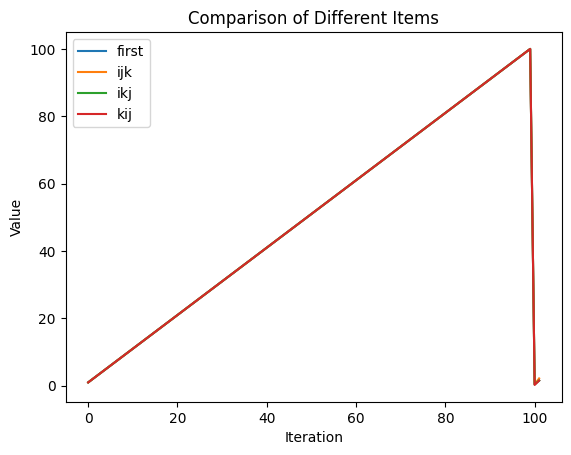

In [88]:
import matplotlib.pyplot as plt

# 定義函式來讀取檔案並提取數據
def read_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        # 忽略前4行並擷取每行的數字
        data = [float(line.split('=')[1].split()[0]) for line in lines[4:]]
    return data

# 讀取檔案並提取數據
first_data = read_file('cuda_gcn/first.txt')
ijk_data = read_file('cuda_gcn/ijk.txt')
ikj_data = read_file('cuda_gcn/ikj.txt')
kij_data = read_file('cuda_gcn/kij.txt')

# 比較數據並繪製圖表
plt.plot(first_data, label='first')
plt.plot(ijk_data, label='ijk')
plt.plot(ikj_data, label='ikj')
plt.plot(kij_data, label='kij')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Comparison of Different Items')
plt.show()


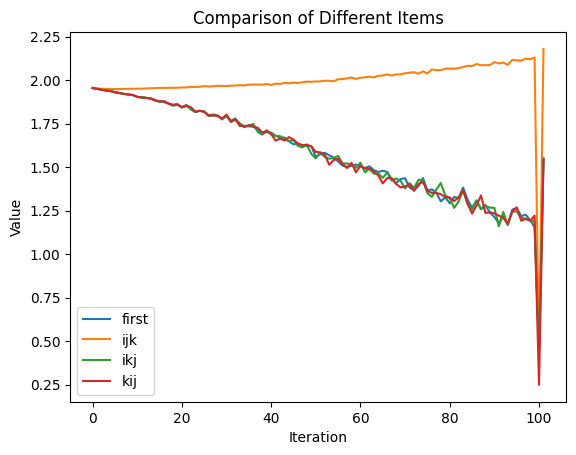

In [89]:
import re
import matplotlib.pyplot as plt

# 定義函式來讀取檔案並提取數據
def read_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        # 使用正則表達式來匹配數字部分
        pattern = r'(\d+\.\d+)'
        data = []
        for line in lines:
            matches = re.findall(pattern, line)
            if len(matches) > 0:
                data.append(float(matches[0]))
    return data

# 讀取檔案並提取數據
first_data = read_file('cuda_gcn/first.txt')
ijk_data = read_file('cuda_gcn/ijk.txt')
ikj_data = read_file('cuda_gcn/ikj.txt')
kij_data = read_file('cuda_gcn/kij.txt')

# 比較數據並繪製圖表
plt.plot(first_data, label='first')
plt.plot(ijk_data, label='ijk')
plt.plot(ikj_data, label='ikj')
plt.plot(kij_data, label='kij')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Comparison of Different Items')
plt.show()


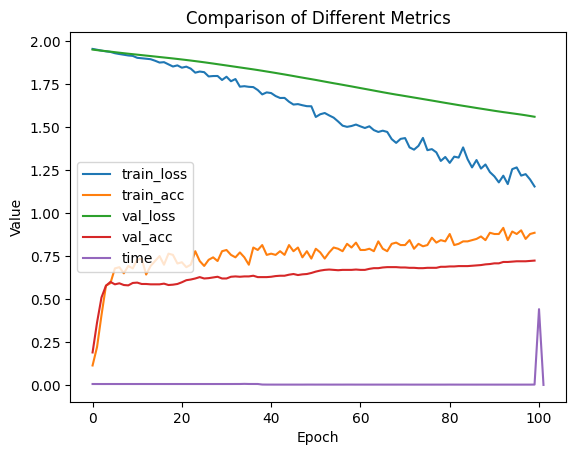

In [90]:
import re
import matplotlib.pyplot as plt

# 定義函式來讀取檔案並提取指定標籤的數值
def read_file(filename, label):
    with open(filename, 'r') as file:
        lines = file.readlines()
        # 使用正則表達式來匹配指定標籤的數值
        pattern = r'{}=(\d+\.\d+)'.format(label)
        data = []
        for line in lines:
            matches = re.findall(pattern, line)
            if len(matches) > 0:
                data.append(float(matches[0]))
    return data

# 讀取檔案並提取指定標籤的數值
first_train_loss = read_file('cuda_gcn/first.txt', 'train_loss')
first_train_acc = read_file('cuda_gcn/first.txt', 'train_acc')
first_val_loss = read_file('cuda_gcn/first.txt', 'val_loss')
first_val_acc = read_file('cuda_gcn/first.txt', 'val_acc')
first_time = read_file('cuda_gcn/first.txt', 'time')

# 比較數據並繪製圖表
plt.plot(first_train_loss, label='train_loss')
plt.plot(first_train_acc, label='train_acc')
plt.plot(first_val_loss, label='val_loss')
plt.plot(first_val_acc, label='val_acc')
plt.plot(first_time, label='time')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Comparison of Different Metrics')
plt.show()


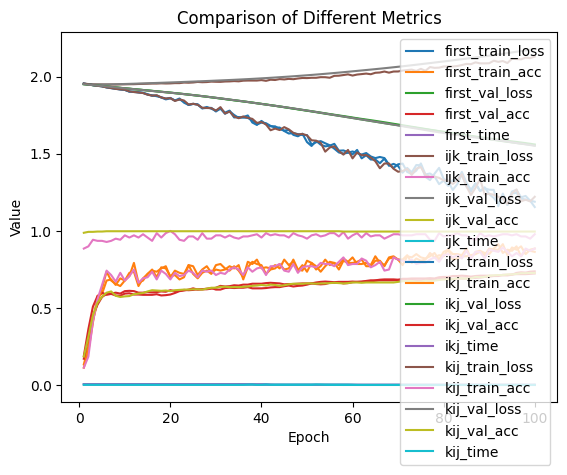

In [92]:
import matplotlib.pyplot as plt

# 定義函式來讀取檔案並提取數據
def read_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        time = []
        for line in lines:
            data = line.strip().split()
            if len(data) == 6:
                epoch = int(data[0].split('=')[1])
                train_loss_value = float(data[1].split('=')[1])
                train_acc_value = float(data[2].split('=')[1])
                val_loss_value = float(data[3].split('=')[1])
                val_acc_value = float(data[4].split('=')[1])
                time_value = float(data[5].split('=')[1])
                train_loss.append((epoch, train_loss_value))
                train_acc.append((epoch, train_acc_value))
                val_loss.append((epoch, val_loss_value))
                val_acc.append((epoch, val_acc_value))
                time.append((epoch, time_value))
    return train_loss, train_acc, val_loss, val_acc, time

# 讀取檔案並提取數據
first_train_loss, first_train_acc, first_val_loss, first_val_acc, first_time = read_file('cuda_gcn/first.txt')
ijk_train_loss, ijk_train_acc, ijk_val_loss, ijk_val_acc, ijk_time = read_file('cuda_gcn/ijk.txt')
ikj_train_loss, ikj_train_acc, ikj_val_loss, ikj_val_acc, ikj_time = read_file('cuda_gcn/ikj.txt')
kij_train_loss, kij_train_acc, kij_val_loss, kij_val_acc, kij_time = read_file('cuda_gcn/kij.txt')

# 比較數據並繪製圖表
plt.plot([epoch for epoch, _ in first_train_loss], [value for _, value in first_train_loss], label='first_train_loss')
plt.plot([epoch for epoch, _ in first_train_acc], [value for _, value in first_train_acc], label='first_train_acc')
plt.plot([epoch for epoch, _ in first_val_loss], [value for _, value in first_val_loss], label='first_val_loss')
plt.plot([epoch for epoch, _ in first_val_acc], [value for _, value in first_val_acc], label='first_val_acc')
plt.plot([epoch for epoch, _ in first_time], [value for _, value in first_time], label='first_time')

plt.plot([epoch for epoch, _ in ijk_train_loss], [value for _, value in ijk_train_loss], label='ijk_train_loss')
plt.plot([epoch for epoch, _ in ijk_train_acc], [value for _, value in ijk_train_acc], label='ijk_train_acc')
plt.plot([epoch for epoch, _ in ijk_val_loss], [value for _, value in ijk_val_loss], label='ijk_val_loss')
plt.plot([epoch for epoch, _ in ijk_val_acc], [value for _, value in ijk_val_acc], label='ijk_val_acc')
plt.plot([epoch for epoch, _ in ijk_time], [value for _, value in ijk_time], label='ijk_time')

plt.plot([epoch for epoch, _ in ikj_train_loss], [value for _, value in ikj_train_loss], label='ikj_train_loss')
plt.plot([epoch for epoch, _ in ikj_train_acc], [value for _, value in ikj_train_acc], label='ikj_train_acc')
plt.plot([epoch for epoch, _ in ikj_val_loss], [value for _, value in ikj_val_loss], label='ikj_val_loss')
plt.plot([epoch for epoch, _ in ikj_val_acc], [value for _, value in ikj_val_acc], label='ikj_val_acc')
plt.plot([epoch for epoch, _ in ikj_time], [value for _, value in ikj_time], label='ikj_time')

plt.plot([epoch for epoch, _ in kij_train_loss], [value for _, value in kij_train_loss], label='kij_train_loss')
plt.plot([epoch for epoch, _ in kij_train_acc], [value for _, value in kij_train_acc], label='kij_train_acc')
plt.plot([epoch for epoch, _ in kij_val_loss], [value for _, value in kij_val_loss], label='kij_val_loss')
plt.plot([epoch for epoch, _ in kij_val_acc], [value for _, value in kij_val_acc], label='kij_val_acc')
plt.plot([epoch for epoch, _ in kij_time], [value for _, value in kij_time], label='kij_time')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Comparison of Different Metrics')
plt.show()
